Note
1. Optimizer Adam, SGD
2. Regularization Ridge Lasso, CV, LOOCV, BN, DropOut, EarlyStop, Data augmentation, Overfitting
    (at epochs when validation accuracy increase = highest genelization or when lowest validation error)
3. Imbalance Data Set: Oversampling, in the loss function (CrossEntropy) change weight
4. Architecture NN: padding, TensorFlow, CrossEntropy with Softmax cause derivate is simple, One-hot coding: (1 0 0) for class 1
5. Selective Search (Region Proposals: alternative of SW), false positif, high recall
6. NMS, Bounding box regression, FCN, Global Average Pooling, Yolo similer to SSD, SegNet : encode - decode
7. SW => R-CNN => Faster R-CNN => Yolo, Faster R-CNN: RPN replace Selective Search, RPN => Mask R-CNN, MNC
8. Add hard negative

# FACE CLASSIFICATION PART

In [63]:
# Load image

import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import random

train_dir = './train_images'  # folder containing training images
test_dir = './test_images'    # folder containing test images

transform = transforms.Compose(
    [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
     transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
     transforms.Normalize(mean=(0.5,),std=(0.5,))]) # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Data augmentation
transform_new = transforms.Compose(
    [transforms.Grayscale(),
     transforms.RandomResizedCrop(36, scale=(0.8, 1.0), ratio=(1, 1)),
     transforms.RandomHorizontalFlip(p=0.8),
     # transforms.RandomVerticalFlip(p=0.1),
     # transforms.RandomRotation((-10, +10)),
     transforms.ToTensor(),    
     transforms.Normalize(mean=(0.5,),std=(0.5,))])

# Resize for training FCN model 
transform_resize = transforms.Compose(
    [transforms.Grayscale(),
     transforms.RandomResizedCrop(72, scale=(0.8, 1.0), ratio=(1, 1)),
     transforms.RandomHorizontalFlip(p=0.8),
     transforms.ToTensor(),    
     transforms.Normalize(mean=(0.5,),std=(0.5,))])
# Resize for testing FCN model 
transform_resize_test = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((72, 72)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,),std=(0.5,))])

# Define two pytorch datasets (train/test) 
train_data_old = ImageFolder(train_dir, transform=transform)
train_data_new = ImageFolder(train_dir, transform=transform_new)
test_data = ImageFolder(test_dir, transform=transform)
# Define resize dataset for FCN model
train_data_resize = ImageFolder(train_dir, transform=transform_resize)
test_data_resize = ImageFolder(test_dir, transform=transform_resize_test)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32    # Mini-Batch

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data_new)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]
# Define randomly the indices of examples to use for training and for validation
num_train_resize = len(train_data_resize)
indices_train_resize = list(range(num_train_resize))
np.random.shuffle(indices_train_resize)
split_tv_resize = int(np.floor(valid_size * num_train_resize))
train_new_idx_resize, valid_idx_resize = indices_train_resize[split_tv_resize:],indices_train_resize[:split_tv_resize]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# Define two "samplers" that will randomly pick examples from the training and validation set for FCN model
train_sampler_resize = SubsetRandomSampler(train_new_idx_resize)
valid_sampler_resize = SubsetRandomSampler(valid_idx_resize)
# Define a "sampler" that will construct automatically a more ballanced training set
imbalance_sampler = ImbalancedDatasetSampler(train_data_new)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = DataLoader(train_data_new, batch_size=batch_size, sampler=train_sampler, num_workers=2)
valid_loader = DataLoader(train_data_new, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
train_loader_ib = DataLoader(train_data_new, batch_size=batch_size, sampler=imbalance_sampler, num_workers=2)
# Dataloaders (take care of loading the data from disk, batch by batch, during training) for FCN model
train_loader_resize = DataLoader(train_data_resize, batch_size=batch_size, sampler=train_sampler_resize, num_workers=2)
valid_loader_resize = DataLoader(train_data_resize, batch_size=batch_size, sampler=valid_sampler_resize, num_workers=2)
test_loader_resize = DataLoader(test_data_resize, batch_size=batch_size, shuffle=True, num_workers=1)

# indicates that "1" means "face" and "0" non-face (only used for display)
classes = ('noface','face')  

In [68]:
# Use Pytorch GPU version

print(torch.__version__)
if torch.cuda.is_available():
    print("CUDA is available.")
    # print(torch.cuda.current_device())
else:
    print("No GPU detected.")
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2.1.0+cu121
CUDA is available.


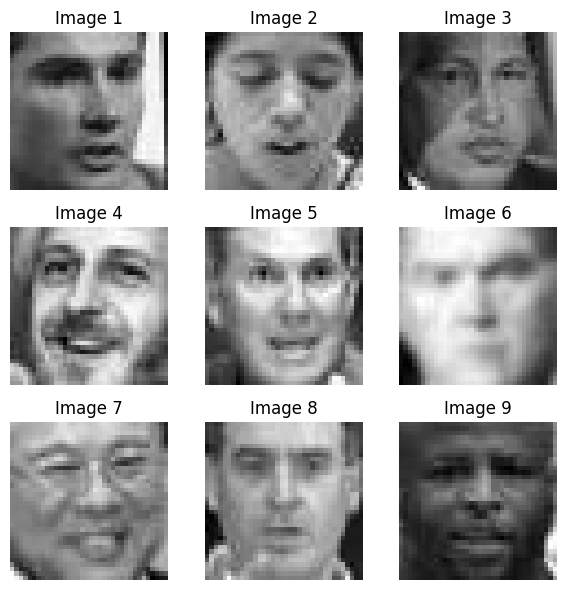

In [5]:
# Visualize original training dataset

image_paths = []
# Load PGM image
for i in range(0, 45, 5):
    index = 1000 + i
    path = (f"./train_images/1/Image00{index}.pgm")
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image_paths.append(path)
    else:
        print("Error: Failed to load the image.")
        
# Display training image examples
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    if i < len(image_paths):
        image = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Turn off axis labels
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

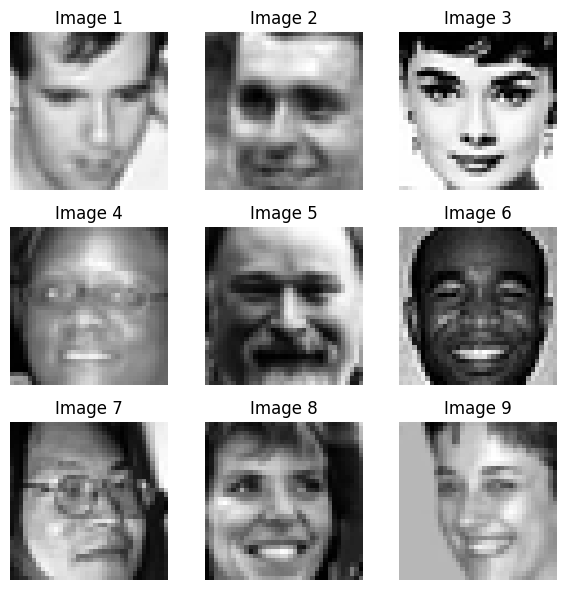

In [6]:
# Visualize test dataset

image_paths_test = []
# Load PGM image
for i in range(1, 82, 10):
    path = (f"./test_images/1/{i}_0__t0,0_r0_s1.pgm")
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image_paths_test.append(path)
    else:
        print("Error: Failed to load the image.")
        
# Display training image examples
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    if i < len(image_paths_test):
        image = cv2.imread(image_paths_test[i], cv2.IMREAD_GRAYSCALE)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Turn off axis labels
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

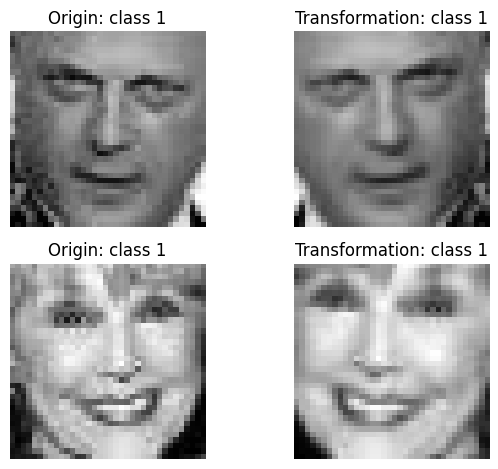

In [7]:
# Visualize transformed image of data augmentation

image_tr_1, label_tr_1 = train_data_new[66666]
image_or_1, label_or_1 = train_data_old[66666]

image_tr_2, label_tr_2 = train_data_new[77777]
image_or_2, label_or_2 = train_data_old[77777]
# Convert the image tensor to a NumPy array for visualization
image_tr_1 = image_tr_1.permute(1, 2, 0).numpy()
image_or_1 = image_or_1.permute(1, 2, 0).numpy()

image_tr_2 = image_tr_2.permute(1, 2, 0).numpy()
image_or_2 = image_or_2.permute(1, 2, 0).numpy()
# Visualize the image using Matplotlib
plt.subplot(2, 2, 1)
plt.imshow(image_or_1, cmap = 'gray')
plt.title(f'Origin: class {label_or_1}')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(image_tr_1, cmap = 'gray')
plt.title(f'Transformation: class {label_tr_1}')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image_or_2, cmap = 'gray')
plt.title(f'Origin: class {label_or_2}')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image_tr_2, cmap = 'gray')
plt.title(f'Transformation: class {label_tr_2}')
plt.axis('off')

plt.tight_layout()
plt.show()

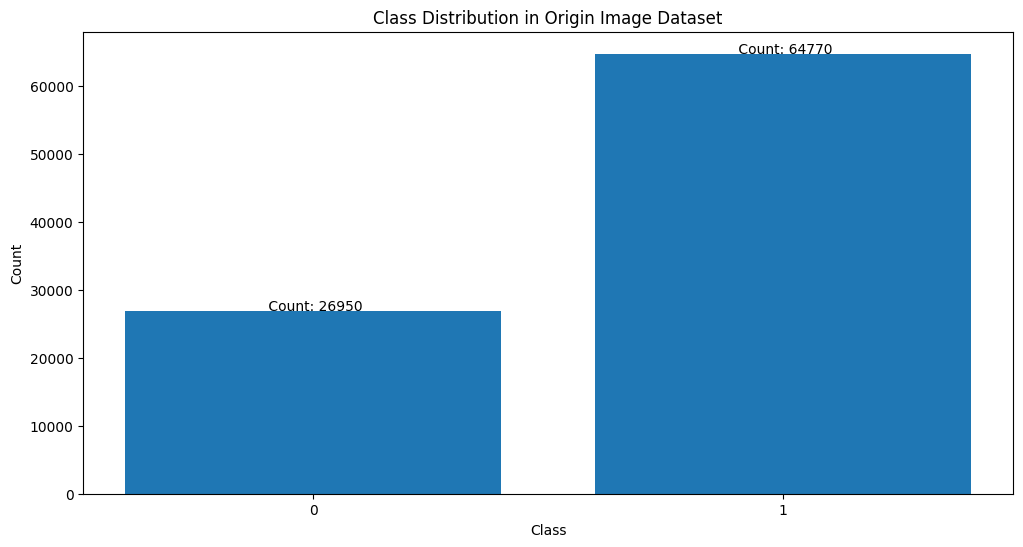

In [8]:
# Display Distribution

# Classification
class_distribution = {}
for _, label in train_data_old:
    class_name = train_data_old.classes[label]
    if class_name in class_distribution:
        class_distribution[class_name] += 1
    else:
        class_distribution[class_name] = 1
        
plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Image Dataset')
# Add custom legend
for class_label, count in class_distribution.items():
    plt.text(class_label, count, f' Count: {count}', ha='center')
plt.show()

In [57]:
# Construct CNN model

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
# Improve CNN model with Drop Out

class Net_new(nn.Module):
    def __init__(self):
        super(Net_new, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.conv3 = nn.Conv2d(16, 16, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.pool(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [59]:
# Train 
n_epochs = 15 # 25
learning_rate = 0.0006 # 0.001
criterion = nn.CrossEntropyLoss()

In [14]:
# SGD
net_sgd = Net().to(device)
optimizer = optim.SGD(net_sgd.parameters(), lr=learning_rate, momentum=0.9)
running_loss_SGD  = []
# loop over epochs: one epoch = one pass through the whole training dataset
for epoch in range(1, n_epochs+1):  
#   loop over iterations: one iteration = 1 batch of examples
    loss_batch = []
    for batch_idx, (data, target) in enumerate(train_loader_ib):
        # Type of data & target is Tensor
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net_sgd(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader_ib.dataset),
                    100. * batch_idx / len(train_loader_ib), loss.data))
        loss_batch.append(loss.data)
    # Take the loss sum of all batch to represent the loss of each iteration
    running_loss_SGD.append(sum(loss_batch))

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.701388
Train Epoch: 1 [91520/91720 (100%)]	Loss: 0.686048
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.688443
Train Epoch: 2 [91520/91720 (100%)]	Loss: 0.623380
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.668983
Train Epoch: 3 [91520/91720 (100%)]	Loss: 0.544289
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.512370
Train Epoch: 4 [91520/91720 (100%)]	Loss: 0.396415
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.154314
Train Epoch: 5 [91520/91720 (100%)]	Loss: 0.218588
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.082480
Train Epoch: 6 [91520/91720 (100%)]	Loss: 0.137227
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.106265
Train Epoch: 7 [91520/91720 (100%)]	Loss: 0.224529
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.243125
Train Epoch: 8 [91520/91720 (100%)]	Loss: 0.297003
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.264881
Train Epoch: 9 [91520/91720 (100%)]	Loss: 0.091874
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.146122
Train Epoch: 10 [91520/91720 (100%)]	Loss: 0.077402
Train Epoch: 11 [0/91720 (0%)]	Loss: 0

In [15]:
# Adam
net_adam = Net().to(device)
optimizer = optim.Adam(net_adam.parameters(), lr=learning_rate)
running_loss_Adam  = []
for epoch in range(1, n_epochs+1):  
    loss_batch = []
    for batch_idx, (data, target) in enumerate(train_loader_ib):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net_adam(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader_ib.dataset),
                    100. * batch_idx / len(train_loader_ib), loss.data))
            loss_batch.append(loss.data)
    running_loss_Adam.append(sum(loss_batch))

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.757216
Train Epoch: 1 [91520/91720 (100%)]	Loss: 0.071361
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.129406
Train Epoch: 2 [91520/91720 (100%)]	Loss: 0.112254
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.105889
Train Epoch: 3 [91520/91720 (100%)]	Loss: 0.052227
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.034519
Train Epoch: 4 [91520/91720 (100%)]	Loss: 0.069752
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.022757
Train Epoch: 5 [91520/91720 (100%)]	Loss: 0.053110
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.207985
Train Epoch: 6 [91520/91720 (100%)]	Loss: 0.338154
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.103854
Train Epoch: 7 [91520/91720 (100%)]	Loss: 0.085425
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.021377
Train Epoch: 8 [91520/91720 (100%)]	Loss: 0.027083
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.046380
Train Epoch: 9 [91520/91720 (100%)]	Loss: 0.057920
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.037430
Train Epoch: 10 [91520/91720 (100%)]	Loss: 0.028060
Train Epoch: 11 [0/91720 (0%)]	Loss: 0

In [8]:
# Drop out
net_new = Net_new().to(device)
optimizer = optim.Adam(net_new.parameters(), lr=learning_rate, weight_decay = 0.001)
running_loss_new  = []
for epoch in range(1, n_epochs+1):  
    loss_batch = []
    for batch_idx, (data, target) in enumerate(train_loader_ib):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net_new(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader_ib.dataset),
                    100. * batch_idx / len(train_loader_ib),loss.data))
        loss_batch.append(loss.data)
    running_loss_new.append(sum(loss_batch))

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.703592
Train Epoch: 1 [91520/91720 (100%)]	Loss: 0.012879
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.042637
Train Epoch: 2 [91520/91720 (100%)]	Loss: 0.013763
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.012759
Train Epoch: 3 [91520/91720 (100%)]	Loss: 0.000521
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.002578
Train Epoch: 4 [91520/91720 (100%)]	Loss: 0.002069
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.008072
Train Epoch: 5 [91520/91720 (100%)]	Loss: 0.002013
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.002624
Train Epoch: 6 [91520/91720 (100%)]	Loss: 0.000859
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.007061
Train Epoch: 7 [91520/91720 (100%)]	Loss: 0.053525
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.003970
Train Epoch: 8 [91520/91720 (100%)]	Loss: 0.103728
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.002386
Train Epoch: 9 [91520/91720 (100%)]	Loss: 0.003528
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.000558
Train Epoch: 10 [91520/91720 (100%)]	Loss: 0.001256
Train Epoch: 11 [0/91720 (0%)]	Loss: 0

In [10]:
# Save the trained model
torch.save(net_new, 'Drop_out_model.pth')
# torch.save(net_sgd, 'SGD_model.pth')
# torch.save(net_adam, 'Adam_model.pth')

In [17]:
# Implement basic "Early Stop" strategy
net_ES = Net().to(device)
optimizer = optim.Adam(net_ES.parameters(), lr=learning_rate)

running_loss_ES  = []

best_loss = float('inf')  # Initialize with a large value for loss
patience = 3  # Number of epochs to wait for metric improvement
wait = 0  # Counter for how many epochs the metric hasn't improved
early_stopped = False  # Flag to check if early stopping occurred

for epoch in range(1, n_epochs+1):
    
    # # # # # # # # #
    # TRAINING LOOP #
    # # # # # # # # #
    
    # Set to training mode
    net_ES.train()
    loss_batch = []
    for batch_idx, (data, target) in enumerate(train_loader_ib):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net_ES(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader_ib.dataset),
                    100. * batch_idx / len(train_loader_ib),loss.data))            
        loss_batch.append(loss.data)
    running_loss_ES.append(sum(loss_batch))
    
    # # # # # # # # # #
    # VALIDATION LOOP #
    # # # # # # # # # #
    
    # Set to evaluation mode
    net_ES.eval()
    with torch.no_grad():
        # Calculate the metric on validation set
        current_loss = 0
        for batch_idx_valid, (data_valid, target_valid) in enumerate(valid_loader): 
            data_valid, target_valid = data_valid.to(device), target_valid.to(device)
            net_out_valid = net_ES(data_valid)
            current_loss += criterion(net_out_valid, target_valid)
        # Check if the metric has improved
        if current_loss < best_loss:
            best_loss = current_loss
            wait = 0
            # Save the model's state
            torch.save(net_ES.state_dict(), 'Eearly_stop_model.pth')
        else:
            wait += 1
        if wait >= patience:
                print(f"Early stopping after {epoch} epochs.")
                early_stopped = True
                break
        
# Load the early stop model if it isn't occur
if not early_stopped:
    net_ES.load_state_dict(torch.load('./Eearly_stop_model.pth'))

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.686901
Train Epoch: 1 [91520/91720 (100%)]	Loss: 0.208211
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.136232
Train Epoch: 2 [91520/91720 (100%)]	Loss: 0.042423
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.178475
Train Epoch: 3 [91520/91720 (100%)]	Loss: 0.260561
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.089772
Train Epoch: 4 [91520/91720 (100%)]	Loss: 0.013037
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.072649
Train Epoch: 5 [91520/91720 (100%)]	Loss: 0.060160
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.016160
Train Epoch: 6 [91520/91720 (100%)]	Loss: 0.039082
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.002657
Train Epoch: 7 [91520/91720 (100%)]	Loss: 0.033609
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.003849
Train Epoch: 8 [91520/91720 (100%)]	Loss: 0.063710
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.054811
Train Epoch: 9 [91520/91720 (100%)]	Loss: 0.031525
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.065787
Train Epoch: 10 [91520/91720 (100%)]	Loss: 0.020915
Train Epoch: 11 [0/91720 (0%)]	Loss: 0

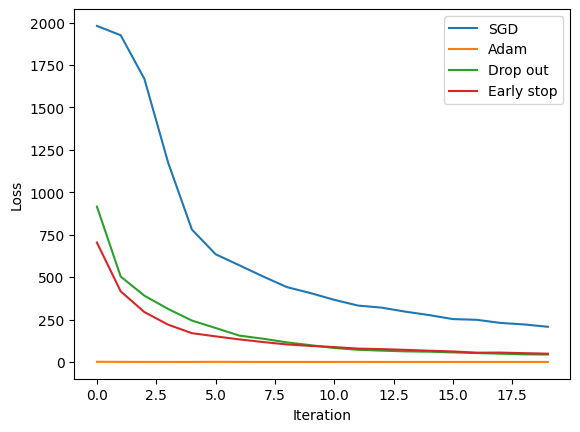

In [22]:
# Visualize the training process
plt.plot(np.array([t.numpy() for t in [tensor.to('cpu') for tensor in running_loss_SGD]]), label='SGD')
plt.plot(np.array([t.numpy() for t in [tensor.to('cpu') for tensor in running_loss_Adam]]), label='Adam')
plt.plot(np.array([t.numpy() for t in [tensor.to('cpu') for tensor in running_loss_new]]), label='Drop out')
plt.plot(np.array([t.numpy() for t in [tensor.to('cpu') for tensor in running_loss_ES]]), label='Early stop')
# Add label and legend
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
# Show the plot
plt.show()

In [25]:
# Test the performance
correct_sgd_train = 0
correct_adam_train = 0
correct_new_train = 0
correct_ES_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_train += labels.size(0)
        # SGD
        outputs_sgd = net_sgd(images)
        _, predicted_sgd = torch.max(outputs_sgd.data, 1)
        correct_sgd_train += (predicted_sgd == labels).sum().item()
        # Adam
        outputs_adam = net_adam(images)
        _, predicted_adam = torch.max(outputs_adam.data, 1)
        correct_adam_train += (predicted_adam == labels).sum().item()
        # Drop out
        outputs_new = net_new(images)
        _, predicted_new = torch.max(outputs_new.data, 1)
        correct_new_train += (predicted_new == labels).sum().item()
        # Early stop
        outputs_ES = net_ES(images)
        _, predicted_ES = torch.max(outputs_ES.data, 1)
        correct_ES_train += (predicted_ES == labels).sum().item()
        
correct_sgd_valid = 0
correct_adam_valid = 0
correct_new_valid = 0
correct_ES_valid = 0
total_valid = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_valid += labels.size(0)
        # SGD
        outputs_sgd = net_sgd(images)
        _, predicted_sgd = torch.max(outputs_sgd.data, 1)
        correct_sgd_valid += (predicted_sgd == labels).sum().item()
        # Adam
        outputs_adam = net_adam(images)
        _, predicted_adam = torch.max(outputs_adam.data, 1)
        correct_adam_valid += (predicted_adam == labels).sum().item()
        # Drop out 
        outputs_new = net_new(images)
        _, predicted_new = torch.max(outputs_new.data, 1)
        correct_new_valid += (predicted_new == labels).sum().item()
        # Early stop
        outputs_ES = net_ES(images)
        _, predicted_ES = torch.max(outputs_ES.data, 1)
        correct_ES_valid += (predicted_ES == labels).sum().item()
     
correct_sgd_test = 0
correct_adam_test = 0
correct_new_test = 0
correct_ES_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_test += labels.size(0)
        # SGD
        outputs_sgd = net_sgd(images)
        _, predicted_sgd = torch.max(outputs_sgd.data, 1)
        correct_sgd_test += (predicted_sgd == labels).sum().item()
        # Adam
        outputs_adam = net_adam(images)
        _, predicted_adam = torch.max(outputs_adam.data, 1)
        correct_adam_test += (predicted_adam == labels).sum().item()
        # Drop out
        outputs_new = net_new(images)
        _, predicted_new = torch.max(outputs_new.data, 1)
        correct_new_test += (predicted_new == labels).sum().item()
        # Early stop
        outputs_ES = net_ES(images)
        _, predicted_ES = torch.max(outputs_ES.data, 1)
        correct_ES_test += (predicted_ES == labels).sum().item()
        
print('Training Set')
print('Accuracy of the network(SGD) on the 73376 train images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_train / total_train), correct_sgd_train, total_train))
print('Accuracy of the network(Adam) on the 73376 train images: {:.4f} %  with  {} / {}'.format((100 * correct_adam_train / total_train), correct_adam_train, total_train))
print('Accuracy of the network(Drop out) on the 73376 train images: {:.4f} %  with  {} / {}'.format((100 * correct_new_train / total_train), correct_new_train, total_train))
print('Accuracy of the network(Early stop) on the 73376 train images: {:.4f} %  with  {} / {}'.format((100 * correct_ES_train / total_train), correct_ES_train, total_train))
print('')
print('Validation Set')
print('Accuracy of the network(SGD) on the 18344 validation images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_valid / total_valid), correct_sgd_valid, total_valid))
print('Accuracy of the network(Adam) on the 18344 validation images: {:.4f} %  with  {} / {}'.format((100 * correct_adam_valid / total_valid), correct_adam_valid, total_valid))
print('Accuracy of the network(Drop out) on the 18344 validation images: {:.4f} %  with  {} / {}'.format((100 * correct_new_valid / total_valid), correct_new_valid, total_valid))
print('Accuracy of the network(Early stop) on the 18344 validation images: {:.4f} %  with  {} / {}'.format((100 * correct_ES_valid / total_valid), correct_ES_valid, total_valid))
print('')
print('Test Set')
print('Accuracy of the network(SGD) on the 7628 test images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_test / total_test), correct_sgd_test, total_test))
print('Accuracy of the network(Adam) on the 7628 test images: {:.4f} %  with  {} / {}'.format((100 * correct_adam_test / total_test), correct_adam_test, total_test))
print('Accuracy of the network(Drop out) on the 7628 test images: {:.4f} %  with  {} / {}'.format((100 * correct_new_test / total_test), correct_new_test, total_test))
print('Accuracy of the network(Early stop) on the 7628 test images: {:.4f} %  with  {} / {}'.format((100 * correct_ES_test / total_test), correct_ES_test, total_test))

Training Set
Accuracy of the network(SGD) on the 73376 train images: 96.4552 %  with 70775 / 73376
Accuracy of the network(Adam) on the 73376 train images: 99.4317 %  with  72959 / 73376
Accuracy of the network(Drop out) on the 73376 train images: 99.3240 %  with  72880 / 73376
Accuracy of the network(Early stop) on the 73376 train images: 99.4644 %  with  72983 / 73376

Validation Set
Accuracy of the network(SGD) on the 18344 validation images: 96.7401 %  with 17746 / 18344
Accuracy of the network(Adam) on the 18344 validation images: 99.5094 %  with  18254 / 18344
Accuracy of the network(Drop out) on the 18344 validation images: 99.4494 %  with  18243 / 18344
Accuracy of the network(Early stop) on the 18344 validation images: 99.5857 %  with  18268 / 18344

Test Set
Accuracy of the network(SGD) on the 7628 test images: 91.8852 %  with 7009 / 7628
Accuracy of the network(Adam) on the 7628 test images: 94.6251 %  with  7218 / 7628
Accuracy of the network(Drop out) on the 7628 test imag

# FACE DETECTION PART

In [60]:
# Load and set to evaluation mode
new_model = torch.load('Drop_out_model.pth') # model_path_new
new_model.eval() 

Net_new(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [7]:
# Implement sliding window & image pyramid (exhaustive search)

def sliding_window(image, step_size, window_size):
    # get the window & image size
    h, w = window_size
    image_h, image_w = image.shape[:2]
    # loop over the image, taking steps of step_size
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            # define the window
            window = image[y:y + h, x:x + w]
            # if the window reaches the end
            if window.shape[:2] != window_size:
                continue
            # yield the current window
            yield (x, y, window)
            
def image_pyramid(image, resize_factor, window_size):
    # stop if image_size < window_size
    while ((image.shape[0], image.shape[1]) >= window_size): 
        yield image
        image = cv2.resize(image, None, fx=resize_factor, fy=resize_factor)

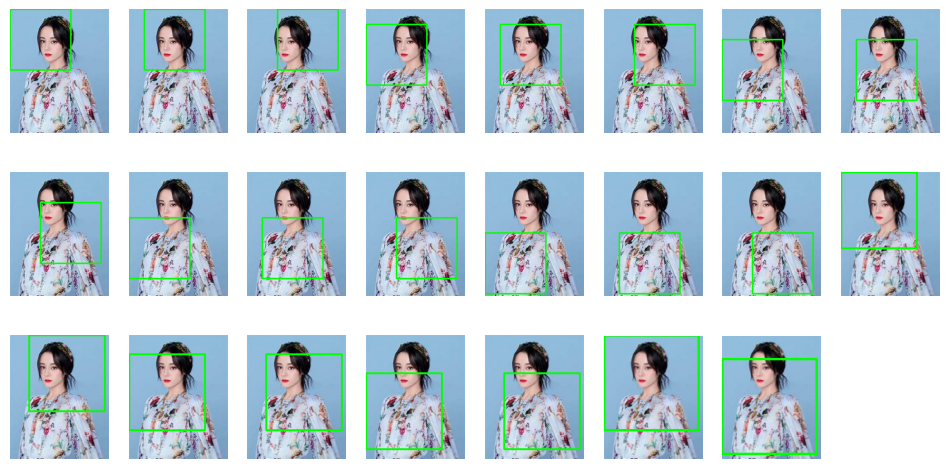

In [8]:
# Visualize the process of sliding window & image pyramid

image_ex = cv2.imread("./dilireba.jpg")
h, w = 120, 120
images_to_display = []
# Image Pyramid
for image in image_pyramid(image_ex, resize_factor=0.8, window_size=(h, w)):
    # Sliding Window
    for (x, y, window) in sliding_window(image, step_size=30, window_size=(h, w)):
        
        clone = image.copy()
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
        images_to_display.append(clone)
        
# Calculate the parameter to display in a grid
num_images = len(images_to_display)
num_columns = 8
num_rows = int(np.ceil(num_images / num_columns))
# Create a figure and display the images in a grid
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 6))
for i, ax in enumerate(axes.ravel()):
    if i < num_images:
        ax.imshow(cv2.cvtColor(images_to_display[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    else:
        # Remove empty subplots
        fig.delaxes(ax)

plt.show()

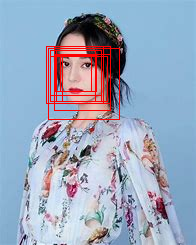

In [9]:
# Visualize the sliding window & image pyramid
from IPython.display import display, Image

image_ex = cv2.imread("./dilireba.jpg") # (245, 196)
h, w = 36, 36 
# Store the face coordinate
face_regions = []
# Superimpose the detected face
superimpose_face = image_ex.copy()
# use to transform coordiante 
scale_factor = 1.0

# Image Pyramid
for image in image_pyramid(image_ex, resize_factor=0.8, window_size=(h, w)):
    # Sliding Window
    for (x, y, window) in sliding_window(image, step_size=5, window_size=(h, w)): # 15, 10, 5
        
        clone = image.copy()
        # Use our best model to predict and annotate faces
        current_window = image[y:y + h, x:x + w]
        # Convert the NumPy array to a PyTorch tensor
        current_window = cv2.cvtColor(current_window, cv2.COLOR_BGR2GRAY)
        # Add an extra dimension to match the batch dimension 
        image_tensor_cpu = torch.from_numpy(current_window).unsqueeze(0).float() / 255.0
        image_tensor_gpu = image_tensor_cpu.to(device)
        # Dectect the face for each window
        outputs_new = new_model(image_tensor_gpu)
        # Show the probability of each class
        probability = F.softmax(outputs_new, dim=1)
        _, predicted_new = torch.max(outputs_new.data, 1)
        if (predicted_new == 1): 
            # # # # # # # # # # # # # # # 
            # Coordinate Transformation #
            # # # # # # # # # # # # # # # 
            x1 = int(x * scale_factor)
            y1 = int(y * scale_factor)
            x2 = int((x + w) * scale_factor)
            y2 = int((y + h) * scale_factor)
            pyramid_coordiante = (x, y, x + w, y + h)
            # Probability for NMS
            origin_coordinate = [x1, y1, x2, y2, probability[0][1].item()]
            face_regions.append(origin_coordinate)
            
        # Display image one by one
        #_, img_png = cv2.imencode('.png', clone)
        #display(Image(data=img_png))
        # Display with OpenCV
        #cv2.imshow("Window", clone)
        #cv2.waitKey(500)
        #cv2.destroyAllWindows()
        
    scale_factor /= 0.8
    
# Draw rectangles on the original image to visualize detected faces
for region in face_regions:
    x1, y1, x2, y2, _ = region
    cv2.rectangle(superimpose_face, (x1, y1), (x2, y2), (0, 0, 255), 1)
_, img_sw_png = cv2.imencode('.png', superimpose_face)
display(Image(data=img_sw_png))

In [10]:
# Implement NMS : Non-maximum suppression & IoU : Intersection over Union

def nms(boxes, threshold):
    keep = []
    while len(boxes) > 0:
        # Select the bounding box with the highest score
        best_box = boxes[0]
        keep.append(best_box)
        # Take remaining boxes
        boxes = boxes[1:]
        # Compute IoU of selected box with remaining boxes
        box_iou = iou(best_box, boxes)
        # Keep boxes that IoU is less than the threshold
        idx = [i for i, val in enumerate(box_iou) if val <= threshold]
        boxes = [boxes[i] for i in idx]
    return keep

def iou(box1, boxes):
    iou = []
    for box2 in boxes:
        # Left Top
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        # Right Bottom
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        # Width Height: intersection area
        w = max(0, x2 - x1)
        h = max(0, y2 - y1)
        inter = w * h
        # Box area
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        # Compute IoU
        iou.append(inter / (area1 + area2 - inter))
    return iou

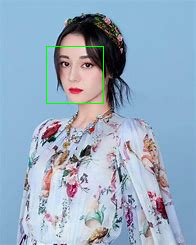

In [11]:
# Visualize the result of NMS

# Sort coordinates by probabilities in descending order
sorted_face_regions = sorted(face_regions, key=lambda x: x[-1], reverse=True)
# Remove probabilities
face_boxes = [region[:-1] for region in sorted_face_regions]
# Use NMS
keep_face = nms(face_boxes, 0.3)
# Visualize NMS rectangle
image_nms = image_ex.copy()
for face in keep_face:
    x1, y1, x2, y2 = face
    cv2.rectangle(image_nms, (x1, y1), (x2, y2), (0, 255, 0), 1)
_, img_nms_png = cv2.imencode('.png', image_nms)
display(Image(data=img_nms_png))

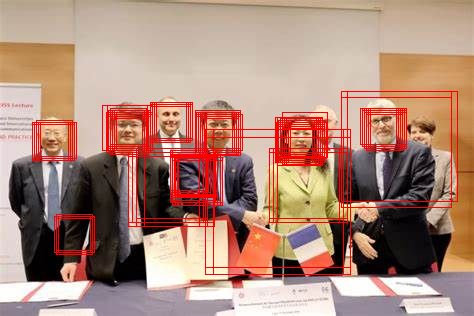

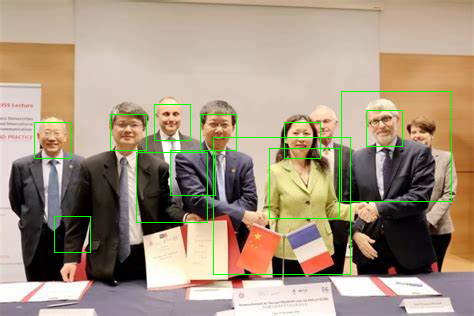

In [19]:
# Visualize sliding window on multi-face image
image_ex_2 = cv2.imread("./CH_FR.jpg") # (474, 316) 
h, w = 36, 36
face_regions_2 = []
superimpose_face_2 = image_ex_2.copy()
scale_factor = 1.0
# Image Pyramid
for image in image_pyramid(image_ex_2, resize_factor=0.8, window_size=(h, w)):
    # Sliding Window
    for (x, y, window) in sliding_window(image, step_size=2, window_size=(h, w)): # 15, 10, 5, 2
        clone = image.copy()
        current_window = image[y:y + h, x:x + w]
        current_window = cv2.cvtColor(current_window, cv2.COLOR_BGR2GRAY) 
        image_tensor = (torch.from_numpy(current_window).unsqueeze(0).float() / 255.0).to(device)
        outputs_new = new_model(image_tensor)
        probability = F.softmax(outputs_new, dim=1)
        _, predicted_new = torch.max(outputs_new.data, 1)
        if (predicted_new == 1): 
            x1 = int(x * scale_factor)
            y1 = int(y * scale_factor)
            x2 = int((x + w) * scale_factor)
            y2 = int((y + h) * scale_factor)
            pyramid_coordiante = (x, y, x + w, y + h)
            origin_coordinate = [x1, y1, x2, y2, probability[0][1].item()]
            face_regions_2.append(origin_coordinate)
    scale_factor /= 0.8
# Draw face region
for region in face_regions_2:
    x1, y1, x2, y2, _ = region
    cv2.rectangle(superimpose_face_2, (x1, y1), (x2, y2), (0, 0, 255), 1)
_, img_sw_png_2 = cv2.imencode('.png', superimpose_face_2)
display(Image(data=img_sw_png_2))
# NMS
sorted_face_regions_2 = sorted(face_regions_2, key=lambda x: x[-1], reverse=True)
face_boxes_2 = [region[:-1] for region in sorted_face_regions_2]
keep_face_2 = nms(face_boxes_2, 0.3)
# Visualize NMS rectangle
image_nms_2 = image_ex_2.copy()
for face in keep_face_2:
    x1, y1, x2, y2 = face
    cv2.rectangle(image_nms_2, (x1, y1), (x2, y2), (0, 255, 0), 1)
_, img_nms_2_png = cv2.imencode('.png', image_nms_2)
display(Image(data=img_nms_2_png))

Total Number of Region Proposals: 267


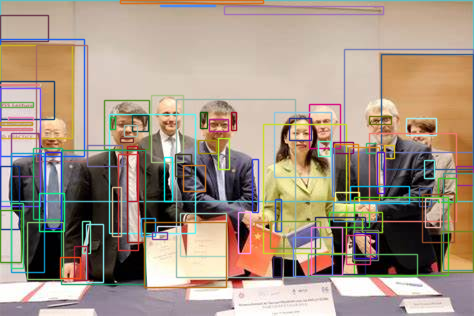

In [76]:
import selectivesearch

# Read the image
im = cv2.imread('./CH_FR.jpg')
# Perform selective search
labs, rects_ss = selectivesearch.selective_search(im, scale=500, sigma=0.8, min_size=50) # (316, 474, 4)
print('Total Number of Region Proposals: {}'.format(len(rects_ss)))
# Number of region proposals to show
num_show_rects = 100
# Visualize SS output
image_ss = im.copy()
# Iterate over region proposals and draw rectangles
for i, rect in enumerate(rects_ss):
    if i < num_show_rects:
        x, y, w, h = rect['rect']
        c1 = random.randint(0, 255)
        c2 = random.randint(0, 255)
        c3 = random.randint(0, 255)
        cv2.rectangle(image_ss, (x, y), (x + w, y + h), (c1, c2, c3), 1, cv2.LINE_AA)
    else:
        break
_, img_ss_png = cv2.imencode('.png', image_ss)
display(Image(data=img_ss_png))

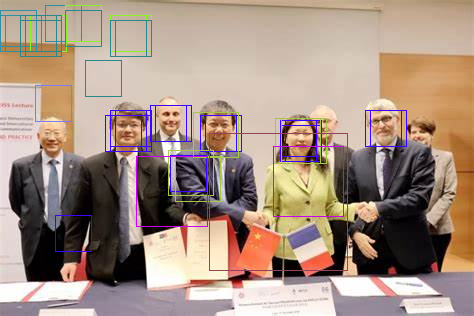

In [80]:
# Implement R-CNN (SS + CNN)

h, w = 36, 36
face_regions_3 = []
# Read the image
im = cv2.imread('./CH_FR.jpg')
for rect in rects_ss: # np.array: (n,)
    x1, y1, x2, y2 = rect['rect']
    p = (x2-x1)/(y2-y1)
    # Skip rectangles with abnormal shape
    if (p > 2 or p < 0.5):
        continue
    current_region = im[y1:y2, x1:x2]
    scale_factor = 1.0
    # Image Pyramid
    for image in image_pyramid(current_region, resize_factor=0.8, window_size=(h, w)):
        face_regions_4 = []
        # Sliding Window
        for (x, y, window) in sliding_window(image, step_size=5, window_size=(h, w)): # 15, 10, 5, 2
            current_window = image[y:y + h, x:x + w]
            current_window = cv2.cvtColor(current_window, cv2.COLOR_BGR2GRAY) 
            image_tensor = (torch.from_numpy(current_window).unsqueeze(0).float() / 255.0).to(device)
            outputs_new = new_model(image_tensor)
            probability = F.softmax(outputs_new, dim=1)
            _, predicted_new = torch.max(outputs_new.data, 1)
            if (predicted_new == 1): 
                x1 = int(x * scale_factor)
                y1 = int(y * scale_factor)
                x2 = int((x + w) * scale_factor)
                y2 = int((y + h) * scale_factor)
                origin_coordinate = [x1, y1, x2, y2, probability[0][1].item()]
                face_regions_4.append(origin_coordinate)
        scale_factor /= 0.8
        if len(face_regions_4) > 0:face_regions_3.append(face_regions_4)
# Draw face region
im_copy = im.copy()
for region in face_regions_3:
    c1 = random.randint(0, 255)
    c2 = random.randint(0, 255)
    c3 = random.randint(0, 255)
    for reg in region:
        x1, y1, x2, y2, _ = reg
        cv2.rectangle(im_copy, (x1, y1), (x2, y2), (c1, c2, c3), 1)
_, img_rcnn_png = cv2.imencode('.png', im_copy)
display(Image(data=img_rcnn_png))
# # NMS
# flatten_face_region = [item[:4] for sublist in face_regions_3 for item in sublist]
# sorted_face_regions_3 = sorted(flatten_face_region, key=lambda x: x[-1], reverse=True)
# face_boxes_3 = [region[:-1] for region in sorted_face_regions_3]
# keep_face_3 = nms(face_boxes_3, 0.3)
# # Visualize NMS rectangle
# image_nms_3 = im.copy()
# for face in keep_face_3:
#     x1, y1, x2, y2 = face
#     cv2.rectangle(image_nms_3, (x1, y1), (x2, y2), (0, 255, 0), 1)
#     _, img_nms_3_png = cv2.imencode('.png', image_nms_3)
# display(Image(data=img_nms_3_png))

In [83]:
# NMS
flatten_face_region = [item[:4] for sublist in face_regions_3 for item in sublist]
sorted_face_regions_3 = sorted(flatten_face_region, key=lambda x: x[-1], reverse=True)
face_boxes_3 = [region[:-1] for region in sorted_face_regions_3]
print(np.array(face_boxes_3).shape)
keep_face_3 = nms(face_boxes_3, 0.3)
# Visualize NMS rectangle
image_nms_3 = im.copy()
for face in keep_face_3:
    x1, y1, x2, y2 = face
    cv2.rectangle(image_nms_3, (x1, y1), (x2, y2), (0, 255, 0), 1)
    _, img_nms_3_png = cv2.imencode('.png', image_nms_3)
display(Image(data=img_nms_3_png))

(220, 3)


IndexError: list index out of range

In [ ]:
# # Use selective search (region proposal) in OpenCV

# # Read image
# im = cv2.imread("./CH_FR.jpg")
# # Resize image
# # newHeight = 200
# # newWidth = int(im.shape[1]*200/im.shape[0])
# # im = cv2.resize(im, (newWidth, newHeight))
# # Create Selective Search Segmentation Object using default parameters
# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
# # Set input image on which we will run segmentation
# ss.setBaseImage(im)
# # Switch to fast but low recall Selective Search method
# ss.switchToSelectiveSearchFast()
# # Switch to high recall but slow Selective Search method
# #ss.switchToSelectiveSearchQuality()
# # Run selective search segmentation on input image
# rects = ss.process()
# print('Total Number of Region Proposals: {}'.format(len(rects)))
# # Number of region proposals
# numShowRects = 100
# # Increment to increase/decrease total number
# # increment = 50

# # Visualize SS output
# image_ss = im.copy()
# # Itereate over all the region proposals
# for i, rect in enumerate(rects):
#     # Draw rectangle for region proposal till numShowRects
#     if (i < numShowRects):
#         x, y, w, h = rect
#         c1 = random.randint(0, 255)
#         c2 = random.randint(0, 255)
#         c3 = random.randint(0, 255)
#         cv2.rectangle(image_ss, (x, y), (x+w, y+h), (c1, c2, c3), 1, cv2.LINE_AA)
#     else:
#         break
# _, img_ss_png = cv2.imencode('.png', image_ss)
# display(Image(data=img_ss_png))

In [ ]:
# # Implement R-CNN (SS + CNN)

# h, w = 36, 36
# face_regions_5 = []
# # Read the image
# im = cv2.imread('./CH_FR.jpg')
# for rect in rects:
#     x1, y1, x2, y2 = rect
#     if (y2 - y1 != 0): 
#         p = (x2-x1)/(y2-y1)
#     else: 
#         continue
#     # Skip rectangles with abnormal shape
#     if (p > 2 or p < 0.5):
#         continue
#     current_region = im[y1:y2, x1:x2]
#     scale_factor = 1
#     # Image Pyramid
#     for image in image_pyramid(current_region, resize_factor=0.8, window_size=(h, w)):
#         face_regions_6 = []
#         # Sliding Window
#         for (x, y, window) in sliding_window(image, step_size=15, window_size=(h, w)): # 15, 10, 5, 2
#             current_window = image[y:y + h, x:x + w]
#             current_window = cv2.cvtColor(current_window, cv2.COLOR_BGR2GRAY) 
#             image_tensor = (torch.from_numpy(current_window).unsqueeze(0).float() / 255.0).to(device)
#             outputs_new = new_model(image_tensor)
#             probability = F.softmax(outputs_new, dim=1)
#             _, predicted_new = torch.max(outputs_new.data, 1)
#             if (predicted_new == 1): 
#                 x1 = int(x * scale_factor)
#                 y1 = int(y * scale_factor)
#                 x2 = int((x + w) * scale_factor)
#                 y2 = int((y + h) * scale_factor)
#                 origin_coordinate = [x1, y1, x2, y2, probability[0][1].item()]
#                 face_regions_6.append(origin_coordinate)
#         scale_factor /= 0.8
#         if len(face_regions_6) > 0:face_regions_5.append(face_regions_6)
# # Draw face region
# im_copy = im.copy()
# for region in face_regions_5:
#     c1 = random.randint(0, 255)
#     c2 = random.randint(0, 255)
#     c3 = random.randint(0, 255)
#     for reg in region:
#         x1, y1, x2, y2, _ = reg
#         cv2.rectangle(im_copy, (x1, y1), (x2, y2), (c1, c2, c3), 1)
# _, img_rcnn_png = cv2.imencode('.png', im_copy)
# display(Image(data=img_rcnn_png))
# # NMS
# flatten_face_region = [item[:4] for sublist in face_regions_5 for item in sublist]
# sorted_face_regions_5 = sorted(flatten_face_region, key=lambda x: x[-1], reverse=True)
# face_boxes_5 = [region[:-1] for region in sorted_face_regions_5]
# keep_face_5 = nms(face_boxes_5, 0.3)
# # Visualize NMS rectangle
# image_nms_5 = im.copy()
# for face in keep_face_5:
#     x1, y1, x2, y2 = face
#     cv2.rectangle(image_nms_5, (x1, y1), (x2, y2), (0, 255, 0), 1)
#     _, img_nms_5_png = cv2.imencode('.png', image_nms_5)
# display(Image(data=img_nms_5_png))

In [48]:
# Implement FCN: Fully Convolutional Networks with GAP: Global Average Pooling

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__() # (128, 128)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool1  = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, dilation=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, dilation=1)
        # Upsampling
        self.deconv1 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)
        self.bn1   = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.bn3   = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.bn4   = nn.BatchNorm2d(16)
        # GAP
        self.global_avg_pool = nn.AdaptiveAvgPool2d(128) 
        self.classifier = nn.Linear(16, 2) 

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 128
        x = self.pool1(x) # 64
        x = F.relu(self.conv2(x)) # 64
        x = self.pool1(x) # 32
        x2 = x
        x = F.relu(self.conv3(x)) # 32
        x = self.pool1(x) # 16
        x3 = x
        x = F.relu(self.conv4(x)) # 16
        x = self.pool1(x) # 8
        x = F.relu(self.conv5(x)) # 8
        x = F.relu(self.conv6(x)) # 8
        # Upsampling
        x = F.relu(self.deconv1(x)) # 16
        x = self.bn1(x + x3) 
        x = F.relu(self.deconv2(x)) # 32
        x = self.bn2(x + x2)
        x = self.bn3(F.relu(self.deconv3(x))) # 64
        x = self.bn4(F.relu(self.deconv4(x))) # 128
        # GAP
        x = torch.mean(x, dim=(2, 3)) 
        x = self.classifier(x)
        return x

In [61]:
# Implement FCN: Fully Convolutional Networks

class Net_FCN(nn.Module):
    def __init__(self):
        super(Net_FCN, self).__init__()
        # Downsampling
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # (72, 72)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        # Upsampling
        # outpadding - 2*padding + kernelsize = 2: (stride) 
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.bn2   = nn.BatchNorm2d(8)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.bn3   = nn.BatchNorm2d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 72
        x = self.pool(x) # 36
        x = F.relu(self.conv2(x)) # 36
        x = self.pool(x) # 18
        # Skip
        x2 = x
        x = F.relu(self.conv3(x)) # 18
        x = self.pool(x) # 9
        # Upsampling
        x = F.relu(self.deconv1(x)) # 18
        x = self.bn1(x + x2)
        x = F.relu(self.deconv2(x)) # 36
        x = self.bn2(x)
        x = self.bn3(F.relu(self.deconv3(x))) # 72
        return x

In [65]:
# Train new architecture FCN

n_epochs = 8
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()

net_fcn = Net_FCN().to(device)
optimizer = optim.Adam(net_fcn.parameters(), lr=learning_rate)
running_loss_FCN  = []
for epoch in range(1, n_epochs+1):  
    loss_batch = []
    for batch_idx, (data, target) in enumerate(train_loader_resize):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net_fcn(data) # (32, 1, 72, 72)
        print(data.shape)
        print(net_out.shape)
        print(target.shape)
        #print(net_out)
        #print(target)
        break
    break
    #     loss = criterion(net_out, target)
    #     loss.backward()
    #     optimizer.step()
    #     if batch_idx % 2860 == 0:
    #         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #                 epoch, batch_idx * len(data), len(train_loader_resize.dataset),
    #                 100. * batch_idx / len(train_loader_resize), loss.data))
    #         loss_batch.append(loss.data)
    # running_loss_FCN.append(sum(loss_batch))

torch.Size([32, 1, 72, 72])
torch.Size([32, 1, 72, 72])
torch.Size([32])


# Note

In [67]:
net_adam = Net().to(device)
optimizer = optim.Adam(net_adam.parameters(), lr=learning_rate)
running_loss_Adam  = []
for epoch in range(1, n_epochs+1):  
    loss_batch = []
    for batch_idx, (data, target) in enumerate(train_loader_ib):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net_adam(data)
        print(data.shape)
        print(net_out.shape) # (32, 2)
        print(target.shape)
        #print(net_out)
        #print(target)
        break
    break
    #     loss = criterion(net_out, target)
    #     loss.backward()
    #     optimizer.step()
    #     if batch_idx % 2860 == 0:
    #         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #                 epoch, batch_idx * len(data), len(train_loader_ib.dataset),
    #                 100. * batch_idx / len(train_loader_ib), loss.data))
    #         loss_batch.append(loss.data)
    # running_loss_Adam.append(sum(loss_batch))

torch.Size([32, 1, 36, 36])
torch.Size([32, 2])
torch.Size([32])


In [66]:
correct_new_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_test += labels.size(0)
        # Drop out
        outputs_new = new_model(images)
        # print(images.shape) # (32, 1, 36, 36)
        # print(outputs_new.shape)
        # print(outputs_new)
        # print(outputs_new.data)
        predicted_val, predicted_new = torch.max(outputs_new.data, 1)
        # print(predicted_new)
        # print(predicted_val)
        # print(labels)
        correct_new_test += (predicted_new == labels).sum().item()
print('Accuracy of the network(Drop out) on the 7628 test images: {:.4f} %  with  {} / {}'.format((100 * correct_new_test / total_test), correct_new_test, total_test))

Accuracy of the network(Drop out) on the 7628 test images: 96.2507 %  with  7342 / 7628


In [ ]:
# Save the FCN model
torch.save(net_fcn, 'FCN_model.pth')

In [30]:
# Test FCN model

correct_fcn_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader_resize:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_train += labels.size(0)
        # FCN
        outputs_fcn = net_fcn(images)
        _, predicted_fcn = torch.max(outputs_fcn.data, 1) # (batch_size, class): (32, 2)
        correct_fcn_train += (predicted_fcn == labels).sum().item()
        
correct_fcn_valid = 0
total_valid = 0
with torch.no_grad():
    for data in valid_loader_resize:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_valid += labels.size(0)
        # FCN
        outputs_fcn = net_fcn(images)
        _, predicted_fcn = torch.max(outputs_fcn.data, 1)
        correct_fcn_valid += (predicted_fcn == labels).sum().item()
     
correct_fcn_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader_resize:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        total_test += labels.size(0)
        # FCN
        outputs_fcn = net_fcn(images)
        _, predicted_fcn = torch.max(outputs_fcn.data, 1)
        correct_fcn_test += (predicted_fcn == labels).sum().item()
        
print('Training Set')
print('Accuracy of the network(FCN) on the 73376 train images: {:.4f} %  with {} / {}'.format((100 * correct_fcn_train / total_train), correct_fcn_train, total_train))
print('')
print('Validation Set')
print('Accuracy of the network(FCN) on the 18344 validation images: {:.4f} %  with {} / {}'.format((100 * correct_fcn_valid / total_valid), correct_fcn_valid, total_valid))
print('')
print('Test Set')
print('Accuracy of the network(FCN) on the 7628 test images: {:.4f} %  with {} / {}'.format((100 * correct_fcn_test / total_test), correct_fcn_test, total_test))

Training Set
Accuracy of the network(FCN) on the 73376 train images: 99.6852 %  with 73145 / 73376

Validation Set
Accuracy of the network(FCN) on the 18344 validation images: 99.6675 %  with 18283 / 18344

Test Set
Accuracy of the network(FCN) on the 7628 test images: 34.4389 %  with 2627 / 7628


In [ ]:
import torchvision.models as models

# Load pre-train Alexnet model in pytorch
alexnet = models.alexnet(pretrained=True)
# Display the architecture
print(alexnet)

# Fin 